# Задание 5

Случайная величина имеет распределение Парето:

$p(x) = \begin{cases} \frac{\theta - 1}{x^\theta}, x \ge 1\\0, x \lt 1 \end{cases}$

$\theta \gt 1$

In [1]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from scipy import integrate
from decimal import Decimal

In [2]:
selection_size = 100
theta = 2
beta = 0.95
alpha = 1 - beta

F = np.array([random.random() for _ in range(selection_size)])
X = np.array([(1 / (1 - F[i]))**(1/(theta - 1)) for i in range(selection_size)])

print(X)

[ 9.04185154  3.10143694  1.1557359   1.35200439  6.58575395  4.08773762
  1.19393683  2.25715732  1.24634701  2.67838016 14.29404094  2.18987889
  5.1547461  12.75911775  1.44646266  1.98202233 21.70570204  1.97110788
 10.1137983   2.84908893  3.64419102 75.83707491  2.72393302  1.08498903
  1.58337379  1.03824534  1.01298151  1.81838439  2.56629625 12.94959171
  1.85033938  2.52364699  1.92670234  1.09201868  1.09589047 27.75487395
  4.96645463  6.1456976   8.3464126   1.27629807  1.45748618  2.36466018
  1.11310673  9.11777913  1.0693712   1.12888442  1.92978564  2.01363596
  7.79089425  1.241664    2.40935169  2.51113008  1.83729323  1.00608741
  2.96681426  5.64447804  2.41168395  2.26099771  1.21684126  1.85732338
  3.86122018  1.71944962  3.50472509  1.94692907  3.23010295  1.75776543
  6.5950792   1.34709066  2.76931635  3.56679043  2.86038625  1.036642
  6.29720441  2.06054424  3.3133637   2.15289521  2.56277724  1.08464632
  2.75741154  1.99589272  1.12765089  1.41646472  1.2

### e) Сгенерируйте выборку объема $n=100$ для некоторого значения параметра $\theta$. Вычислите указанные доверительные интервалы для доверительной вероятности $0.95$.

Асимптотический доверительный интервал медианы по ОМП

In [4]:
theta_est = 1 + len(X) / np.sum([np.log(x) for x in X])
median_est = 2 ** (1 / (theta_est - 1))
U_min = -1.96
U_max = +1.96


asymptotic_median_min = U_min * (np.log(2) * median_est) / (np.sqrt(len(X)) * (theta_est - 1)) + median_est
asymptotic_median_max = U_max * (np.log(2) * median_est) / (np.sqrt(len(X)) * (theta_est - 1)) + median_est

print(f'({asymptotic_median_min}; {asymptotic_median_max})')

(1.7002817651771653; 2.216148166471111)


Баесовский доверительный интервал

In [20]:
def integral_equation(f, a0, b0, q, err, C):
    a = a0
    b = b0
    
    while True:
        A, e = integrate.quad(f, a0, (a + b)/2)
        A /= C
        if np.abs(A - q) < err:
            b = (a + b)/2
            break
        if A > q:
            b = (a + b)/2
        else:
            a = (a + b)/2
    
    return b

X1_n = Decimal(1)
for i in range(len(X)):
    X1_n *= Decimal(X[i])

f = lambda x: Decimal(math.exp(1-Decimal(x)))/Decimal(Decimal(X1_n)**Decimal(x)) * Decimal(x-1)**Decimal(len(X))
C, err = integrate.quad(f, 1, theta * 2)

q0025 = integral_equation(f, 1, theta*4, alpha / 2, 0.00001, C)
q0975 = integral_equation(f, 1, theta*4, beta + alpha / 2, 0.00001, C)

bayes_min = q0025
bayes_max = q0975

print(f'({bayes_min}; {bayes_max})')

(1.8398590087890625; 2.2416839599609375)


Асимптотический доверительный интервал параметра $\theta$

In [5]:
theta_est = 1 + len(X) / np.sum([np.log(x) for x in X])
U_min = -1.96
U_max = +1.96

asymptotic_min = theta_est - (theta_est - 1) / len(X)**0.5 * U_max
asymptotic_max = theta_est - (theta_est - 1) / len(X)**0.5 * U_min

print(f'({asymptotic_min}; {asymptotic_max})')

(1.8292599654685748; 2.2335757695278797)


### f) Численно постройте бутстраповский доверительный интервал двумя способами, используя параметрический и непараметрический бутстрап.

Бутстраповский (непараметрический) доверительный интервал

In [6]:
theta_est = lambda X : 1 + len(X) / np.sum([np.log(x) for x in X])
N = 1000

subselections = [[X[random.randint(0,len(X)-1)] for i in range(len(X))] for j in range(N)]
deltas = [theta_est(subselections[i]) - theta_est(X) for i in range(N)]
deltas = np.sort(deltas)

k1 = int(N * (1 - beta) / 2) - 1
k2 = int(N * (1 + beta) / 2) - 1

nonparametric_bootstrap_min = deltas[k1] + theta_est(X)
nonparametric_bootstrap_max = deltas[k2] + theta_est(X)

print(f'({nonparametric_bootstrap_min}; {nonparametric_bootstrap_max})')

(1.8696486200958744; 2.2340115310032216)


Бутстраповский (параметрический) доверительный интервал

In [7]:
theta_est = lambda X : 1 + len(X) / np.sum([np.log(x) for x in X])
theta_ = theta_est(X)
N = 50000

subselections = [[(1 / (1 - random.random()))**(1/(theta - 1)) for i in range(len(X))] for j in range(N)]
theta_ests = [theta_est(subselections[i]) for i in range(N)]
theta_ests = np.sort(theta_ests)

k1 = int(N * (1 - beta) / 2) - 1
k2 = int(N * (1 + beta) / 2) - 1

parametric_bootstrap_min = theta_ests[k1]
parametric_bootstrap_max = theta_ests[k2]

print(f'({parametric_bootstrap_min}; {parametric_bootstrap_max})')

(1.8284150855892864; 2.227386468811646)


### g) Сравнить все интервалы

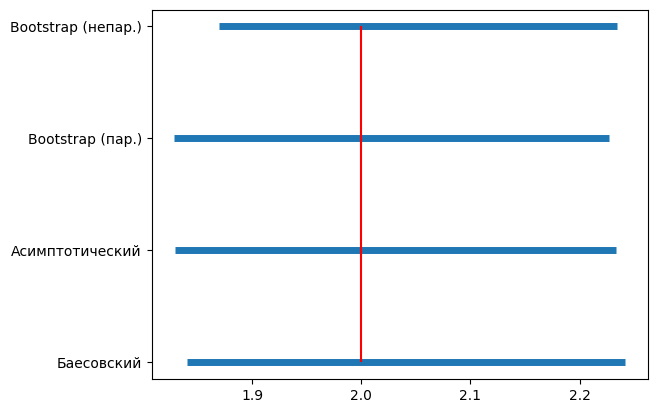

In [15]:
I_min = [bayes_min, asymptotic_min, parametric_bootstrap_min, nonparametric_bootstrap_min]
I_max = [bayes_max, asymptotic_max, parametric_bootstrap_max, nonparametric_bootstrap_max]

x = ["Баесовский", "Асимптотический", "Bootstrap (пар.)", "Bootstrap (непар.)"]

fig, ax = plt.subplots()

ax.hlines(x, I_min, I_max, linewidth=5)
ax.vlines(theta, 0, len(x)-1, colors=['red'])

plt.show()